In [1]:
!python --version

Python 3.9.1


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convolutional Autoencoder for Denoising Galaxy Images

In this simple demonstration, we will build a convolutional autoencoder specifically designed for denoising a set of galaxy images with the same dimensions. Autoencoders are a type of artificial neural network (ANN) designed to pick up common patterns from input training data in order to refine and validate by attempting to replicate the input. The type of ANN that we are going to use is the convolutional neural network (CNN), which are more suited for colored images than the usual dense layers. Thus, the combination of these neural network types will give us a **convolutional autoencoder**.

#### Preliminaries

- generate file directories for our input and output storage. 

In [3]:
import os

In [4]:
try:
    os.makedirs('Data//Input')
except OSError:
    pass

try:
    os.makedirs('Data//Output//DataFrame')
except OSError:
    pass

try:
    os.makedirs('Data//Output//Models')
except OSError:
    pass

try:
    os.makedirs('Data//Output//Plots//Individual')
except OSError:
    pass

# I. Download [Galaxy10 SDSS](https://astronn.readthedocs.io/en/latest/galaxy10sdss.html) dataset from [`AstroNN`](https://astronn.readthedocs.io/en/latest/)

&emsp;

- From AstroNN:


<div>
<img src="https://astronn.readthedocs.io/en/latest/_images/galaxy10sdss_example.png" width="800"/>
</div>

<blockquote>
    Galaxy10 SDSS is a dataset contains 21785 69x69 pixels colored galaxy images (g, r and i band) separated in 10 classes. Galaxy10 SDSS images come from <a href="http://www.sdss.org/" >Sloan Digital Sky Survey</a> and labels come from <a href="https://www.zooniverse.org/projects/zookeeper/galaxy-zoo/" >Galaxy Zoo</a>.
</blockquote>

- We can import the galaxy10 SDSS dataset using AstroNN as follows:

In [5]:
from astroNN.datasets import load_galaxy10

WARNING! APOGEE environment variable SDSS_LOCAL_SAS_MIRROR not set
WARNING! Gaia environment variable GAIA_TOOLS_DATA not set


In [6]:
images, labels = load_galaxy10()

C:\Users\Lanz\.astroNN\datasets\Galaxy10.h5 was found!


- Split the image dataset using sklearn's `train_test_split`. 
- We will only be using the image data since we are not building a classification algorithm.
- This means we will only need `train_images` and `test_images`.
- Generally we want to have more training data than testing data.
- We will add some noise on both of these sets later.

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
np.random.seed(42069)
train_idx, test_idx = train_test_split(np.arange(labels.shape[0]), 
                                       test_size=0.1)

train_images, train_labels = images[train_idx], labels[train_idx]
test_images, test_labels = images[test_idx], labels[test_idx]

- Each image is represented by a numpy array containing values from 0 to 255.
- We divide each image data and in turn each array element, by 255 in order to limit the range of values from 0 to 1.
- This is called normalization of the range of values from 0 to 1. We do this in order to make the computations faster, helping our autoencoder to learn more efficiently.

In [9]:
train_images, test_images = train_images/255, test_images/255

- By checking the shape of `train_images` and `test_images`, we can see that we have almost 20,000 training data and more than 2000 test data. 
- We can also see that the images have dimensions 69x69 and are have 3 channels, meaning they are colored.

In [10]:
train_images.shape

(19606, 69, 69, 3)

In [11]:
test_images.shape

(2179, 69, 69, 3)

# II. Add Gaussian Noise to images

- We can use `TensorFlow`'s `GaussianNoise` in order to add artificial noise to our image data.
- Noise can occur in image data collected from various instruments especially CCD cameras (charged-coupled device).
- These are caused by some disturbances on the circuitry of the CCD from its environment. 

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import GaussianNoise

- We can add a mild Gaussian noise of 0.2 to `train_images` to produce a separate array of images called `noisy_train_images`.

In [13]:
tf.random.set_seed(420)
sample = GaussianNoise(0.2)

noisy_train_images = sample(train_images, training=True)
noisy_test_images = sample(test_images, training=True)

- We clip the images since adding Gaussian noise will cause some image array values that get out our preferred range of 0 to 1.

In [14]:
noisy_train_images = np.clip(noisy_train_images, 0, 1)
noisy_test_images = np.clip(noisy_test_images, 0, 1)

- Preview the first training image and its equivalent noised image.

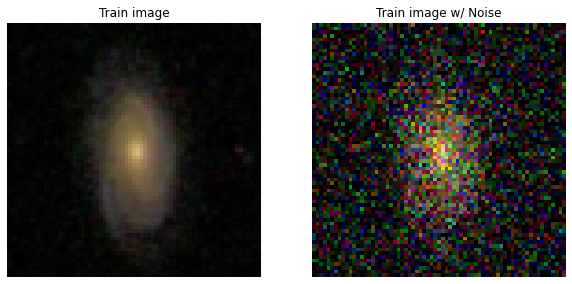

In [15]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].imshow(train_images[0])
ax[0].set(title='Train image')
ax[1].imshow(np.clip(noisy_train_images[0], 0, 1))
ax[1].set(title='Train image w/ Noise')

for axs in ax.reshape(-1):
    axs.axis(False)

# III. Prepare Autoencoder

In [16]:
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD

#### The Architecture of our Neural Network

- Autoencoders are composed of two parts: the encoder and the decoder.
    - The encoder reduces the dimension of the input data (compresses), preserving the most important components.
    - The decoder produces an expanded version of the encoder output (decompresses), retaining only the important components. 
    - Since noise is not the important component of these images, then the autoencoders will eliminate them, therefore 'denoising' the noisy images.
- For now, my preferred architecture is a set of alternating convolutional and max pooling layer for the decoders, and a set of alternating convolutional and upsampling layers for the decoder.
    - I tried adding more paired layers for both encoder and decoders and tested their training output but a single pair for each is what worked best so far.
- The architecture is dependent on the dimensions of the input images, specifically the `pool_size` of `MaxPool2D` and`size` of `UpSampling2D` is dependent. However, the selection of the number of filters and kernel size is arbitrary. 
- The 3 filters in the last convolutional layer of `decoder` are for the color channels.

In [17]:
tf.random.set_seed(420)
np.random.seed(69)


encoder = Sequential()
encoder.add(Conv2D(filters=23, kernel_size=(3,3), 
                   input_shape=(69,69,3),
                   activation='relu', padding='same'))
encoder.add(MaxPool2D(pool_size=(3, 3), padding='same'))


decoder = Sequential()
decoder.add(Conv2D(filters=23, kernel_size=(3,3), 
                   activation='relu', padding='same'))
decoder.add(UpSampling2D(size=(3, 3)))

decoder.add(Conv2D(filters=3, kernel_size=(3,3), 
                   activation='sigmoid', padding='same'))

- We combine `encoder` and `decoder` in order to form our autoencoder, which we'll refer to as `gal10_autoencoder`.
- For our optimizer, we choose the [Adam algorithm](https://keras.io/api/optimizers/adam/) and mean squared error (MSE) for the loss function.
- We would want to track the accuracy of our autoencoder's performance.

In [18]:
gal10_autoencoder = Sequential([encoder, decoder])
gal10_autoencoder.compile(loss="mse", 
                          optimizer='adam', 
                          #optimizer=SGD(learning_rate=1.5), 
                          metrics=['accuracy'])

- preview encoder summary

In [19]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 69, 69, 23)        644       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 23)       0         
 )                                                               
                                                                 
Total params: 644
Trainable params: 644
Non-trainable params: 0
_________________________________________________________________


- preview decoder summary

In [20]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 23, 23, 23)        4784      
                                                                 
 up_sampling2d (UpSampling2D  (None, 69, 69, 23)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 69, 69, 3)         624       
                                                                 
Total params: 5,408
Trainable params: 5,408
Non-trainable params: 0
_________________________________________________________________


- preview `gal10_autoencoder` summary

In [21]:
gal10_autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 23, 23, 23)        644       
                                                                 
 sequential_1 (Sequential)   (None, 69, 69, 3)         5408      
                                                                 
Total params: 6,052
Trainable params: 6,052
Non-trainable params: 0
_________________________________________________________________


# IV. Run the Autoencoder

- In case `gal10_autoencoder`'s performance does not improve, we can stop its training through `early_stop`. 
- If the validation loss does not further decrease after 3 epochs, the training stops.

In [22]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

- To finally train `gal10_autoencoder`, we select 20 epochs and a batch size of 100.
    - We train on the original training and noised training images then use the original test and noised test images for validation.
- We would also like to save this trained network so that we could deploy it for future use.

In [23]:
%%time
gal10_autoencoder.fit(noisy_train_images, train_images, 
                      epochs=20, batch_size=100, 
                      #shuffle=True,
                      callbacks=[early_stop], 
                      validation_data=(noisy_test_images, test_images))

gal10_autoencoder.save('Data/Output/Models/gal10_denoiser.h5')

Epoch 1/20
197/197 [==============================] - 48s 241ms/step - loss: 0.0316 - accuracy: 0.2505 - val_loss: 0.0232 - val_accuracy: 0.2569
Epoch 2/20
197/197 [==============================] - 47s 238ms/step - loss: 0.0161 - accuracy: 0.4260 - val_loss: 0.0016 - val_accuracy: 0.6597
Epoch 3/20
197/197 [==============================] - 47s 237ms/step - loss: 0.0012 - accuracy: 0.6699 - val_loss: 9.1386e-04 - val_accuracy: 0.6759
Epoch 4/20
197/197 [==============================] - 46s 235ms/step - loss: 8.6662e-04 - accuracy: 0.6883 - val_loss: 8.0333e-04 - val_accuracy: 0.6900
Epoch 5/20
197/197 [==============================] - 46s 233ms/step - loss: 7.9776e-04 - accuracy: 0.6939 - val_loss: 7.6027e-04 - val_accuracy: 0.6959
Epoch 6/20
197/197 [==============================] - 46s 233ms/step - loss: 7.6599e-04 - accuracy: 0.6920 - val_loss: 7.4312e-04 - val_accuracy: 0.6882
Epoch 7/20
197/197 [==============================] - 46s 233ms/step - loss: 7.4083e-04 - accuracy: 0.

- To save the performance metrics, we save `gal10_autoencoder`'s history as `autoencoder_history`, which we can convert to a dataframe for visualization and perhaps, later analysis.

In [24]:
autoencoder_history = gal10_autoencoder.history.history

- We save the output dataframe, and plots for accuracy and loss in their respective directories.

In [25]:
losses_df = pd.DataFrame(autoencoder_history)
losses_df.to_csv('Data/Output/DataFrame/gal10_autoencoder_perf.csv', index=False)

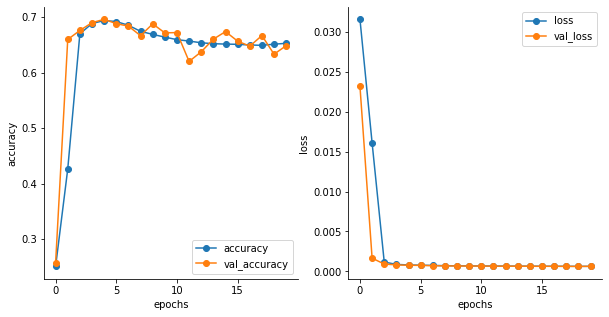

In [26]:
losses_df = pd.DataFrame(autoencoder_history)

fig, ax = plt.subplots(1,2, figsize=(10,5))

losses_df[['accuracy','val_accuracy']].plot(ax=ax[0], marker='o')
ax[0].set(ylabel='accuracy')
losses_df[['loss','val_loss']].plot(ax=ax[1], marker='o')
ax[1].set(ylabel='loss')

for axs in ax.reshape(-1):
    axs.spines['right'].set_visible(False)
    axs.spines['top'].set_visible(False)
    axs.tick_params(left=True, bottom=True, 
                   labelleft=True, labelbottom=True)
    axs.set(xlabel='epochs')
    
fig.savefig('Data/Output/Plots/gal10_autoencoder_perf.png', dpi=200)

- We can see that at epochs 5 and beyond, there's little change to our training metrics, aside from the minor fluctuations in the validation accuracy.

# V. Deploy Autoencoder

- We can deploy saved models by loading them. 

- Now we can denoised the noisy test images and store the results in `denoised_images`.
- Remember that `gal10_autoencoder` has no idea at all about th

In [27]:
%%time
denoised_images = gal10_autoencoder.predict(noisy_test_images)

69/69 [==============================] - 1s 15ms/step
CPU times: total: 11.1 s
Wall time: 1.21 s


In [28]:
len(denoised_images)

2179

- Denoising more than 2000 images took only less than 2 seconds.

- We can visualize the results of `gal10_autoencoder` for the first 6 test images. 

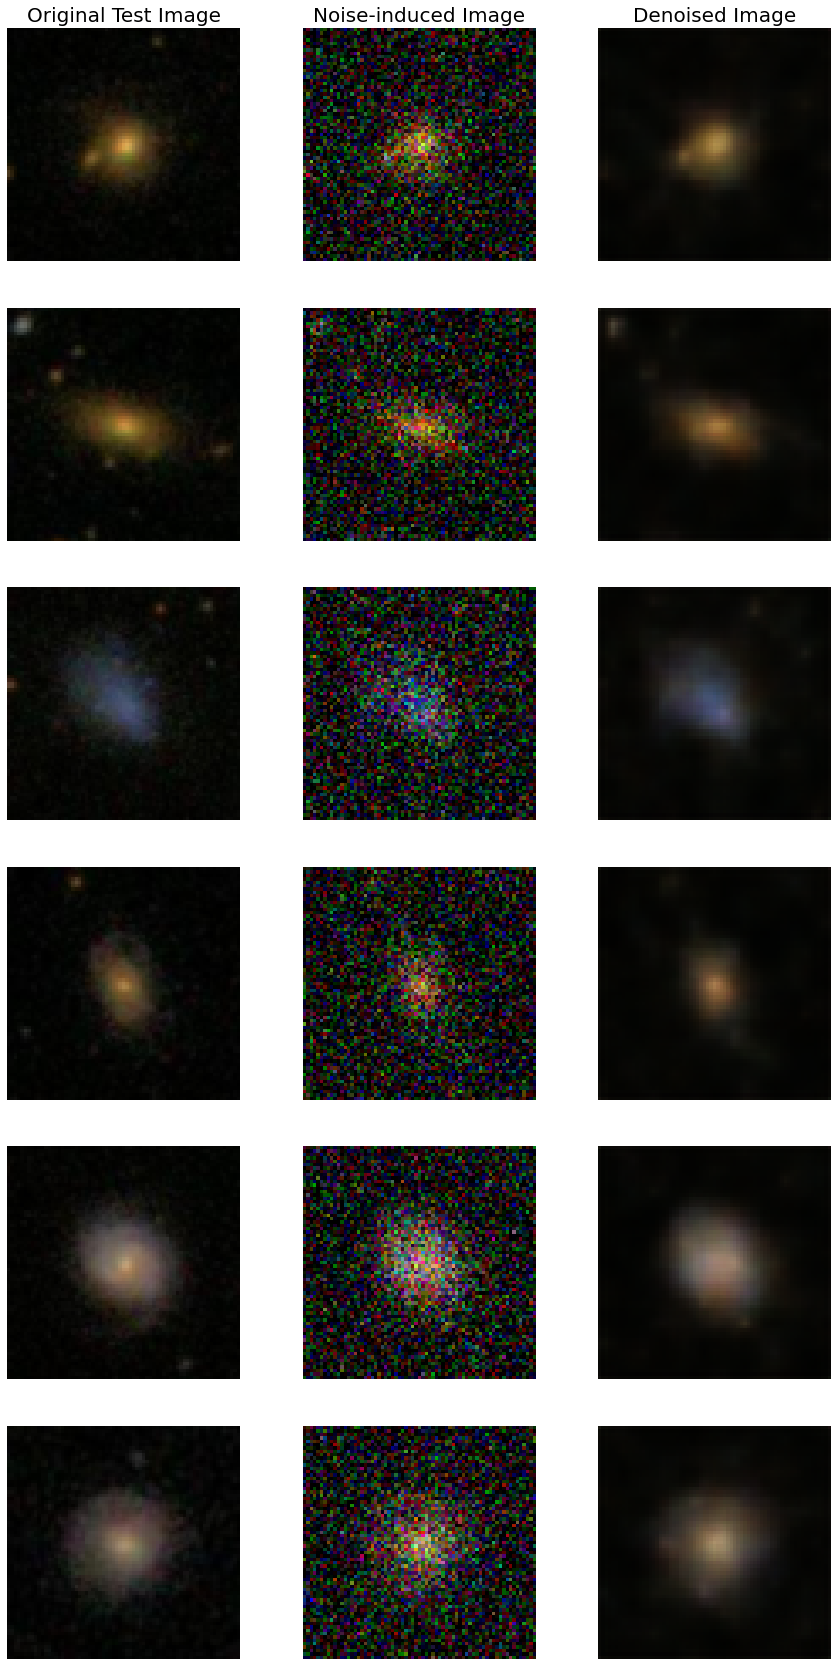

In [29]:
n_images = 6
n_test_images = test_images[:n_images]
n_noisy_test_images = noisy_test_images[:n_images]
n_denoised_images = denoised_images[:n_images]

fig, ax = plt.subplots(n_images,3, figsize=(5*3,5*n_images))

ax[0, 0].set_title('Original Test Image', fontsize=20)
ax[0, 1].set_title('Noise-induced Image', fontsize=20)
ax[0, 2].set_title('Denoised Image', fontsize=20)
for i in range(n_images):
    
    ax[i, 0].imshow(n_test_images[i])
    ax[i, 1].imshow(n_noisy_test_images[i])
    ax[i, 2].imshow(n_denoised_images[i])

    for axs in ax.reshape(-1):
        axs.axis(False)
        axs.spines['right'].set_visible(False)
        axs.spines['top'].set_visible(False)
        axs.tick_params(left=True, bottom=True, 
                       labelleft=True, labelbottom=True)
        
fig.savefig('Data/Output/Plots/gal10_autoencoder_output_overview_gnoise_0.2.png', dpi=300)

- We can see that while the noise has been cleanly removed, we inevitably lose some of the details; the definition of the arms of some galaxies and the surrounding smaller light sources are diminished. 
- However, we achieved our main goal of preserving the main objects from each of our input images. 

- We can finally save all the outputs of `gal10_autoencoder`.

In [30]:
%%time
for i in range(len(test_images)):
    fig, ax = plt.subplots(1,3, figsize=(15,5))

    ax[0].set_title('Original Test Image', fontsize=20)
    ax[1].set_title('Noise-induced Image', fontsize=20)
    ax[2].set_title('Denoised Image', fontsize=20)


    ax[0].imshow(test_images[i])
    ax[1].imshow(noisy_test_images[i])
    ax[2].imshow(denoised_images[i])

    for axs in ax.reshape(-1):
        axs.axis(False)
        axs.spines['right'].set_visible(False)
        axs.spines['top'].set_visible(False)
        axs.tick_params(left=True, bottom=True, 
                       labelleft=True, labelbottom=True)

    fig.savefig(f'Data/Output/Plots/Individual/gal10_autoencoder_output_image_{i:04d}.png', dpi=150)
    plt.close();
    plt.clf()
    
    print(f'output_image_{i:04d}.png saved')

output_image_0000.png saved
output_image_0001.png saved
output_image_0002.png saved
output_image_0003.png saved
output_image_0004.png saved
output_image_0005.png saved
output_image_0006.png saved
output_image_0007.png saved
output_image_0008.png saved
output_image_0009.png saved
output_image_0010.png saved
output_image_0011.png saved
output_image_0012.png saved
output_image_0013.png saved
output_image_0014.png saved
output_image_0015.png saved
output_image_0016.png saved
output_image_0017.png saved
output_image_0018.png saved
output_image_0019.png saved
output_image_0020.png saved
output_image_0021.png saved
output_image_0022.png saved
output_image_0023.png saved
output_image_0024.png saved
output_image_0025.png saved
output_image_0026.png saved
output_image_0027.png saved
output_image_0028.png saved
output_image_0029.png saved
output_image_0030.png saved
output_image_0031.png saved
output_image_0032.png saved
output_image_0033.png saved
output_image_0034.png saved
output_image_0035.pn

output_image_0293.png saved
output_image_0294.png saved
output_image_0295.png saved
output_image_0296.png saved
output_image_0297.png saved
output_image_0298.png saved
output_image_0299.png saved
output_image_0300.png saved
output_image_0301.png saved
output_image_0302.png saved
output_image_0303.png saved
output_image_0304.png saved
output_image_0305.png saved
output_image_0306.png saved
output_image_0307.png saved
output_image_0308.png saved
output_image_0309.png saved
output_image_0310.png saved
output_image_0311.png saved
output_image_0312.png saved
output_image_0313.png saved
output_image_0314.png saved
output_image_0315.png saved
output_image_0316.png saved
output_image_0317.png saved
output_image_0318.png saved
output_image_0319.png saved
output_image_0320.png saved
output_image_0321.png saved
output_image_0322.png saved
output_image_0323.png saved
output_image_0324.png saved
output_image_0325.png saved
output_image_0326.png saved
output_image_0327.png saved
output_image_0328.pn

output_image_0587.png saved
output_image_0588.png saved
output_image_0589.png saved
output_image_0590.png saved
output_image_0591.png saved
output_image_0592.png saved
output_image_0593.png saved
output_image_0594.png saved
output_image_0595.png saved
output_image_0596.png saved
output_image_0597.png saved
output_image_0598.png saved
output_image_0599.png saved
output_image_0600.png saved
output_image_0601.png saved
output_image_0602.png saved
output_image_0603.png saved
output_image_0604.png saved
output_image_0605.png saved
output_image_0606.png saved
output_image_0607.png saved
output_image_0608.png saved
output_image_0609.png saved
output_image_0610.png saved
output_image_0611.png saved
output_image_0612.png saved
output_image_0613.png saved
output_image_0614.png saved
output_image_0615.png saved
output_image_0616.png saved
output_image_0617.png saved
output_image_0618.png saved
output_image_0619.png saved
output_image_0620.png saved
output_image_0621.png saved
output_image_0622.pn

output_image_0881.png saved
output_image_0882.png saved
output_image_0883.png saved
output_image_0884.png saved
output_image_0885.png saved
output_image_0886.png saved
output_image_0887.png saved
output_image_0888.png saved
output_image_0889.png saved
output_image_0890.png saved
output_image_0891.png saved
output_image_0892.png saved
output_image_0893.png saved
output_image_0894.png saved
output_image_0895.png saved
output_image_0896.png saved
output_image_0897.png saved
output_image_0898.png saved
output_image_0899.png saved
output_image_0900.png saved
output_image_0901.png saved
output_image_0902.png saved
output_image_0903.png saved
output_image_0904.png saved
output_image_0905.png saved
output_image_0906.png saved
output_image_0907.png saved
output_image_0908.png saved
output_image_0909.png saved
output_image_0910.png saved
output_image_0911.png saved
output_image_0912.png saved
output_image_0913.png saved
output_image_0914.png saved
output_image_0915.png saved
output_image_0916.pn

output_image_1175.png saved
output_image_1176.png saved
output_image_1177.png saved
output_image_1178.png saved
output_image_1179.png saved
output_image_1180.png saved
output_image_1181.png saved
output_image_1182.png saved
output_image_1183.png saved
output_image_1184.png saved
output_image_1185.png saved
output_image_1186.png saved
output_image_1187.png saved
output_image_1188.png saved
output_image_1189.png saved
output_image_1190.png saved
output_image_1191.png saved
output_image_1192.png saved
output_image_1193.png saved
output_image_1194.png saved
output_image_1195.png saved
output_image_1196.png saved
output_image_1197.png saved
output_image_1198.png saved
output_image_1199.png saved
output_image_1200.png saved
output_image_1201.png saved
output_image_1202.png saved
output_image_1203.png saved
output_image_1204.png saved
output_image_1205.png saved
output_image_1206.png saved
output_image_1207.png saved
output_image_1208.png saved
output_image_1209.png saved
output_image_1210.pn

output_image_1468.png saved
output_image_1469.png saved
output_image_1470.png saved
output_image_1471.png saved
output_image_1472.png saved
output_image_1473.png saved
output_image_1474.png saved
output_image_1475.png saved
output_image_1476.png saved
output_image_1477.png saved
output_image_1478.png saved
output_image_1479.png saved
output_image_1480.png saved
output_image_1481.png saved
output_image_1482.png saved
output_image_1483.png saved
output_image_1484.png saved
output_image_1485.png saved
output_image_1486.png saved
output_image_1487.png saved
output_image_1488.png saved
output_image_1489.png saved
output_image_1490.png saved
output_image_1491.png saved
output_image_1492.png saved
output_image_1493.png saved
output_image_1494.png saved
output_image_1495.png saved
output_image_1496.png saved
output_image_1497.png saved
output_image_1498.png saved
output_image_1499.png saved
output_image_1500.png saved
output_image_1501.png saved
output_image_1502.png saved
output_image_1503.pn

output_image_1761.png saved
output_image_1762.png saved
output_image_1763.png saved
output_image_1764.png saved
output_image_1765.png saved
output_image_1766.png saved
output_image_1767.png saved
output_image_1768.png saved
output_image_1769.png saved
output_image_1770.png saved
output_image_1771.png saved
output_image_1772.png saved
output_image_1773.png saved
output_image_1774.png saved
output_image_1775.png saved
output_image_1776.png saved
output_image_1777.png saved
output_image_1778.png saved
output_image_1779.png saved
output_image_1780.png saved
output_image_1781.png saved
output_image_1782.png saved
output_image_1783.png saved
output_image_1784.png saved
output_image_1785.png saved
output_image_1786.png saved
output_image_1787.png saved
output_image_1788.png saved
output_image_1789.png saved
output_image_1790.png saved
output_image_1791.png saved
output_image_1792.png saved
output_image_1793.png saved
output_image_1794.png saved
output_image_1795.png saved
output_image_1796.pn

output_image_2055.png saved
output_image_2056.png saved
output_image_2057.png saved
output_image_2058.png saved
output_image_2059.png saved
output_image_2060.png saved
output_image_2061.png saved
output_image_2062.png saved
output_image_2063.png saved
output_image_2064.png saved
output_image_2065.png saved
output_image_2066.png saved
output_image_2067.png saved
output_image_2068.png saved
output_image_2069.png saved
output_image_2070.png saved
output_image_2071.png saved
output_image_2072.png saved
output_image_2073.png saved
output_image_2074.png saved
output_image_2075.png saved
output_image_2076.png saved
output_image_2077.png saved
output_image_2078.png saved
output_image_2079.png saved
output_image_2080.png saved
output_image_2081.png saved
output_image_2082.png saved
output_image_2083.png saved
output_image_2084.png saved
output_image_2085.png saved
output_image_2086.png saved
output_image_2087.png saved
output_image_2088.png saved
output_image_2089.png saved
output_image_2090.pn

<Figure size 432x288 with 0 Axes>

# To-do List

- Improve markdowns for deeper but more beginner-friendly discussion.
- Construct a custom function `gal10_autoencoder_builder` that automatically builds the autoencoder architecture based on the dimensionality of input data.
    - This will be deployed for denoising [Galaxy10 DECals](https://astronn.readthedocs.io/en/latest/galaxy10.html) image datasets that are composed of 17736 images with dimensions of 256x256.
- Try to deploy on a set of randomly-noised (not just 0.2) image sets.